In [ ]:
import os
import glob
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf

2024-06-05 01:44:45.104269: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 01:44:45.104367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 01:44:45.231668: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import os

# Set CUDA_VISIBLE_DEVICES to utilize both T4 GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

# **Loading Data**

# **Loading 140 k Real and Fake**

In [ ]:
path  = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/'

In [ ]:
#Load 70 k Real and 70 k Fake StyleGAN 1 data
dataset = {"image_path":[],"img_status":[]}
for where in os.listdir(path):
    for status in os.listdir(path+"/"+where):
        for image in glob.glob(path+where+"/"+status+"/"+"*.jpg"):
            dataset["image_path"].append(image)
            dataset["img_status"].append(status)


dataset = pd.DataFrame(dataset)
dataset

image_path img_status
0       /kaggle/input/140k-real-and-fake-faces/real_vs...       fake
1       /kaggle/input/140k-real-and-fake-faces/real_vs...       fake
2       /kaggle/input/140k-real-and-fake-faces/real_vs...       fake
3       /kaggle/input/140k-real-and-fake-faces/real_vs...       fake
4       /kaggle/input/140k-real-and-fake-faces/real_vs...       fake
...                                                   ...        ...
139995  /kaggle/input/140k-real-and-fake-faces/real_vs...       real
139996  /kaggle/input/140k-real-and-fake-faces/real_vs...       real
139997  /kaggle/input/140k-real-and-fake-faces/real_vs...       real
139998  /kaggle/input/140k-real-and-fake-faces/real_vs...       real
139999  /kaggle/input/140k-real-and-fake-faces/real_vs...       real

[140000 rows x 2 columns]

In [ ]:
# write model name 'SG' infront of Fake data
dataset['img_status'] = dataset['img_status'].apply(lambda x: 'SG' if x == 'fake' else x)

In [ ]:
dataset

image_path img_status
0       /kaggle/input/140k-real-and-fake-faces/real_vs...         SG
1       /kaggle/input/140k-real-and-fake-faces/real_vs...         SG
2       /kaggle/input/140k-real-and-fake-faces/real_vs...         SG
3       /kaggle/input/140k-real-and-fake-faces/real_vs...         SG
4       /kaggle/input/140k-real-and-fake-faces/real_vs...         SG
...                                                   ...        ...
139995  /kaggle/input/140k-real-and-fake-faces/real_vs...       real
139996  /kaggle/input/140k-real-and-fake-faces/real_vs...       real
139997  /kaggle/input/140k-real-and-fake-faces/real_vs...       real
139998  /kaggle/input/140k-real-and-fake-faces/real_vs...       real
139999  /kaggle/input/140k-real-and-fake-faces/real_vs...       real

[140000 rows x 2 columns]

In [ ]:
#remove 35 k from fake styleGAN 1 data

# Assuming you have a DataFrame named dataset
# Filter the DataFrame to include only rows where img_status equals "fake"
fake_rows = dataset[dataset['img_status'] == 'SG']

# Check if the number of fake rows is greater than 20,000
if len(fake_rows) > 30500:
    # Randomly sample 20,000 rows
    sample_indices = np.random.choice(fake_rows.index, size=30500, replace=False)

    # Create a new DataFrame without the sampled rows
    dataset = dataset.drop(index=sample_indices)

    print("35,000 random fake records deleted. New DataFrame created.")
else:
    print("There are less than 20,000 fake records in the DataFrame.")

35,000 random fake records deleted. New DataFrame created.


In [ ]:
dataset


image_path img_status
0       /kaggle/input/140k-real-and-fake-faces/real_vs...         SG
1       /kaggle/input/140k-real-and-fake-faces/real_vs...         SG
2       /kaggle/input/140k-real-and-fake-faces/real_vs...         SG
3       /kaggle/input/140k-real-and-fake-faces/real_vs...         SG
4       /kaggle/input/140k-real-and-fake-faces/real_vs...         SG
...                                                   ...        ...
139995  /kaggle/input/140k-real-and-fake-faces/real_vs...       real
139996  /kaggle/input/140k-real-and-fake-faces/real_vs...       real
139997  /kaggle/input/140k-real-and-fake-faces/real_vs...       real
139998  /kaggle/input/140k-real-and-fake-faces/real_vs...       real
139999  /kaggle/input/140k-real-and-fake-faces/real_vs...       real

[109500 rows x 2 columns]

In [ ]:
dataset.value_counts("img_status")

img_status
real    70000
SG      39500
Name: count, dtype: int64

# **Loading Celeba-hq 256 Dataset (Real Faces)**

In [ ]:
import os
import glob
import pandas as pd

# Define the path for the new dataset
path_real2 = '/kaggle/input/celebahq-resized-256x256/celeba_hq_256'

real2_data = {"image_path": [], "img_status": []}

for image_file in glob.glob(os.path.join(path_real2, '*.jpg')):
    status = "real"
    real2_data["image_path"].append(image_file)
    real2_data["img_status"].append(status)

real2_df = pd.DataFrame(real2_data)

print(real2_df)


                                              image_path img_status
0      /kaggle/input/celebahq-resized-256x256/celeba_...       real
1      /kaggle/input/celebahq-resized-256x256/celeba_...       real
2      /kaggle/input/celebahq-resized-256x256/celeba_...       real
3      /kaggle/input/celebahq-resized-256x256/celeba_...       real
4      /kaggle/input/celebahq-resized-256x256/celeba_...       real
...                                                  ...        ...
29995  /kaggle/input/celebahq-resized-256x256/celeba_...       real
29996  /kaggle/input/celebahq-resized-256x256/celeba_...       real
29997  /kaggle/input/celebahq-resized-256x256/celeba_...       real
29998  /kaggle/input/celebahq-resized-256x256/celeba_...       real
29999  /kaggle/input/celebahq-resized-256x256/celeba_...       real

[30000 rows x 2 columns]


In [ ]:
path1 = "/kaggle/input/synthetic-human-faces-for-3d-reconstruction/eg3d_synthetic_faces/eg3d_synthetic_faces"

eg3d = {"image_path": [], "img_status": []}

for image_file in os.listdir(path1):
    if image_file.endswith(".png"):
        eg3d["image_path"].append(os.path.join(path1, image_file))
        eg3d["img_status"].append("3D")


eg3d = pd.DataFrame(eg3d)
print(eg3d)


                                              image_path img_status
0      /kaggle/input/synthetic-human-faces-for-3d-rec...         3D
1      /kaggle/input/synthetic-human-faces-for-3d-rec...         3D
2      /kaggle/input/synthetic-human-faces-for-3d-rec...         3D
3      /kaggle/input/synthetic-human-faces-for-3d-rec...         3D
4      /kaggle/input/synthetic-human-faces-for-3d-rec...         3D
...                                                  ...        ...
49239  /kaggle/input/synthetic-human-faces-for-3d-rec...         3D
49240  /kaggle/input/synthetic-human-faces-for-3d-rec...         3D
49241  /kaggle/input/synthetic-human-faces-for-3d-rec...         3D
49242  /kaggle/input/synthetic-human-faces-for-3d-rec...         3D
49243  /kaggle/input/synthetic-human-faces-for-3d-rec...         3D

[49244 rows x 2 columns]


In [ ]:
#remove 14244 k from fake EG3D 1 data
# Assuming you have a DataFrame named dataset
# Filter the DataFrame to include only rows where img_status equals "fake"
fake_rows = eg3d[eg3d['img_status'] == '3D']

# Check if the number of fake rows is greater than 20,000
if len(fake_rows) > 14244:
    # Randomly sample 20,000 rows
    sample_indices = np.random.choice(fake_rows.index, size=14244, replace=False)

    # Create a new DataFrame without the sampled rows
    eg3d = eg3d.drop(index=sample_indices)

    print("14244 random fake records deleted. New DataFrame created.")
else:
    print("There are less than 20,000 fake records in the DataFrame.")

14244 random fake records deleted. New DataFrame created.


In [ ]:
eg3d.value_counts("img_status")

img_status
3D    35000
Name: count, dtype: int64

# **Load Synthetic Faces part 2 Dataset (Fake Faces)**

In [ ]:
path2 = '/kaggle/input/synthetic-faces-high-quality-sfhq-part-2/images/images'

# Create a dictionary to store image paths and labels
sfhq2 = {"image_path": [], "img_status": []}

# Loop through the files in the directory
for image_file in os.listdir(path2):
    if image_file.endswith(".jpg"):
        # Append the image path and label to the dictionary
        sfhq2["image_path"].append(os.path.join(path2, image_file))
        sfhq2["img_status"].append("SFHQ2")
sfhq2 = pd.DataFrame( sfhq2)
print( sfhq2)
# # Remove 93,358 images from the data
# if len(sfhq_df) > 66400:
#     # Randomly sample 66400 rows
#     sample_indices = np.random.choice(sfhq_df.index, size=66400, replace=False)

#     # Create a new DataFrame without the sampled rows
#     sfhq_df = sfhq_df.drop(index=sample_indices)

#     print("66400 random records deleted. New DataFrame created.")
# else:
#     print("There are less than 66400 records in the DataFrame.")


                                              image_path img_status
0      /kaggle/input/synthetic-faces-high-quality-sfh...      SFHQ2
1      /kaggle/input/synthetic-faces-high-quality-sfh...      SFHQ2
2      /kaggle/input/synthetic-faces-high-quality-sfh...      SFHQ2
3      /kaggle/input/synthetic-faces-high-quality-sfh...      SFHQ2
4      /kaggle/input/synthetic-faces-high-quality-sfh...      SFHQ2
...                                                  ...        ...
91356  /kaggle/input/synthetic-faces-high-quality-sfh...      SFHQ2
91357  /kaggle/input/synthetic-faces-high-quality-sfh...      SFHQ2
91358  /kaggle/input/synthetic-faces-high-quality-sfh...      SFHQ2
91359  /kaggle/input/synthetic-faces-high-quality-sfh...      SFHQ2
91360  /kaggle/input/synthetic-faces-high-quality-sfh...      SFHQ2

[91361 rows x 2 columns]


In [ ]:
# Convert the dictionary to a DataFrame
sfhq_df2 = pd.DataFrame(sfhq2)

# Take random 25,000 records
sfhq_df2 = sfhq_df2.sample(n=25000, random_state=42)

print(sfhq_df2)

                                              image_path img_status
75864  /kaggle/input/synthetic-faces-high-quality-sfh...      SFHQ2
9187   /kaggle/input/synthetic-faces-high-quality-sfh...      SFHQ2
84507  /kaggle/input/synthetic-faces-high-quality-sfh...      SFHQ2
70552  /kaggle/input/synthetic-faces-high-quality-sfh...      SFHQ2
33664  /kaggle/input/synthetic-faces-high-quality-sfh...      SFHQ2
...                                                  ...        ...
82299  /kaggle/input/synthetic-faces-high-quality-sfh...      SFHQ2
74521  /kaggle/input/synthetic-faces-high-quality-sfh...      SFHQ2
46445  /kaggle/input/synthetic-faces-high-quality-sfh...      SFHQ2
64894  /kaggle/input/synthetic-faces-high-quality-sfh...      SFHQ2
59936  /kaggle/input/synthetic-faces-high-quality-sfh...      SFHQ2

[25000 rows x 2 columns]


# **Loading Synthetic Faces part 3 (Fake Faces)**

In [ ]:
import random
# Define the directory paths
images_path = '/kaggle/input/synthetic-faces-high-quality-sfhq-part-3/images/images'
small_samples_path = '/kaggle/input/synthetic-faces-high-quality-sfhq-part-3/a small samples (750 images)'
tiny_samples_path = '/kaggle/input/synthetic-faces-high-quality-sfhq-part-3/a tiny sample (130 images)'

# Initialize lists to store file paths
image_file_paths = []
small_sample_paths = []
tiny_sample_paths = []

# Collect file paths from the 'images' folder
for file_name in os.listdir(images_path):
    if file_name.endswith(".jpg"):
        file_path = os.path.join(images_path, file_name)
        image_file_paths.append(file_path)


# Take 25k random file paths from the 'images' folder
random.shuffle(image_file_paths)
sampled_image_paths = image_file_paths[:25000]

all_file_paths = sampled_image_paths + small_sample_paths + tiny_sample_paths

# Create a dictionary to store the combined data
sfhq3 = {"image_path": all_file_paths, "img_status": ["SFHQ"] * len(all_file_paths)}

# Create a DataFrame
sfhq3_df = pd.DataFrame(sfhq3)

print(sfhq3_df.head())

print("Length of the combined data:", len(sfhq3_df))

                                          image_path img_status
0  /kaggle/input/synthetic-faces-high-quality-sfh...       SFHQ
1  /kaggle/input/synthetic-faces-high-quality-sfh...       SFHQ
2  /kaggle/input/synthetic-faces-high-quality-sfh...       SFHQ
3  /kaggle/input/synthetic-faces-high-quality-sfh...       SFHQ
4  /kaggle/input/synthetic-faces-high-quality-sfh...       SFHQ
Length of the combined data: 25000


In [ ]:
synthetic = pd.concat([sfhq3_df, sfhq_df2], ignore_index=True)

print("Length of the synthetic dataset:", len(synthetic))

Length of the synthetic dataset: 50000


# **Loading Stable diffuion (Fake Faces)**

In [ ]:
sd = {"image_path": [], "img_status": []}
base_path = '/kaggle/input/stable-diffusion-dataaaaaaaaa/stable-diffusion-face-dataset'

# Mapping for model names based on folder names
model_mapping = {
    '768': 'SD 2.1',
    '512': 'SD 1.5',
    '1024': 'SD XL'
}

# Populate the dataset dictionary
for where in os.listdir(base_path):  # Main folders (768, 512, 1024)
    where_path = os.path.join(base_path, where)
    if os.path.isdir(where_path):  # Check if it's a directory
        for gender in os.listdir(where_path):  # Subfolders (man, woman)
            gender_path = os.path.join(where_path, gender)
            if os.path.isdir(gender_path):  # Check if it's a directory
                images_path = gender_path
                for image in glob.glob(images_path + "/*.jpg"):  # Image files
                    sd["image_path"].append(image)
                    sd["img_status"].append("fake")  # Assuming all images are fake for now

# Create DataFrame
sd = pd.DataFrame(sd)
print(sd)


                                             image_path img_status
0     /kaggle/input/stable-diffusion-dataaaaaaaaa/st...       fake
1     /kaggle/input/stable-diffusion-dataaaaaaaaa/st...       fake
2     /kaggle/input/stable-diffusion-dataaaaaaaaa/st...       fake
3     /kaggle/input/stable-diffusion-dataaaaaaaaa/st...       fake
4     /kaggle/input/stable-diffusion-dataaaaaaaaa/st...       fake
...                                                 ...        ...
8995  /kaggle/input/stable-diffusion-dataaaaaaaaa/st...       fake
8996  /kaggle/input/stable-diffusion-dataaaaaaaaa/st...       fake
8997  /kaggle/input/stable-diffusion-dataaaaaaaaa/st...       fake
8998  /kaggle/input/stable-diffusion-dataaaaaaaaa/st...       fake
8999  /kaggle/input/stable-diffusion-dataaaaaaaaa/st...       fake

[9000 rows x 2 columns]


# **Loading Stable diffusion v 1.4 (Fake Faces)**

In [ ]:
path4 = "/kaggle/input/faces-dataset-using-stable-diffusion-v14/"

sd3 = {"image_path": [], "img_status": []}

for where in os.listdir(path4):
    if where != "invalid" and os.path.isdir(os.path.join(path4, where)):  # Skip "invalid" folder
        for status in os.listdir(os.path.join(path4, where)):
            if os.path.isdir(os.path.join(path4, where, status)):  # Check if it's a directory
                for image in glob.glob(os.path.join(path4, where, status, "*.png")):
                    sd3["image_path"].append(image)
                    sd3["img_status"].append('sd3')

sd3 = pd.DataFrame(sd3)
print(sd3)


                                             image_path img_status
0     /kaggle/input/faces-dataset-using-stable-diffu...        sd3
1     /kaggle/input/faces-dataset-using-stable-diffu...        sd3
2     /kaggle/input/faces-dataset-using-stable-diffu...        sd3
3     /kaggle/input/faces-dataset-using-stable-diffu...        sd3
4     /kaggle/input/faces-dataset-using-stable-diffu...        sd3
...                                                 ...        ...
2531  /kaggle/input/faces-dataset-using-stable-diffu...        sd3
2532  /kaggle/input/faces-dataset-using-stable-diffu...        sd3
2533  /kaggle/input/faces-dataset-using-stable-diffu...        sd3
2534  /kaggle/input/faces-dataset-using-stable-diffu...        sd3
2535  /kaggle/input/faces-dataset-using-stable-diffu...        sd3

[2536 rows x 2 columns]


# **Visualising Data**

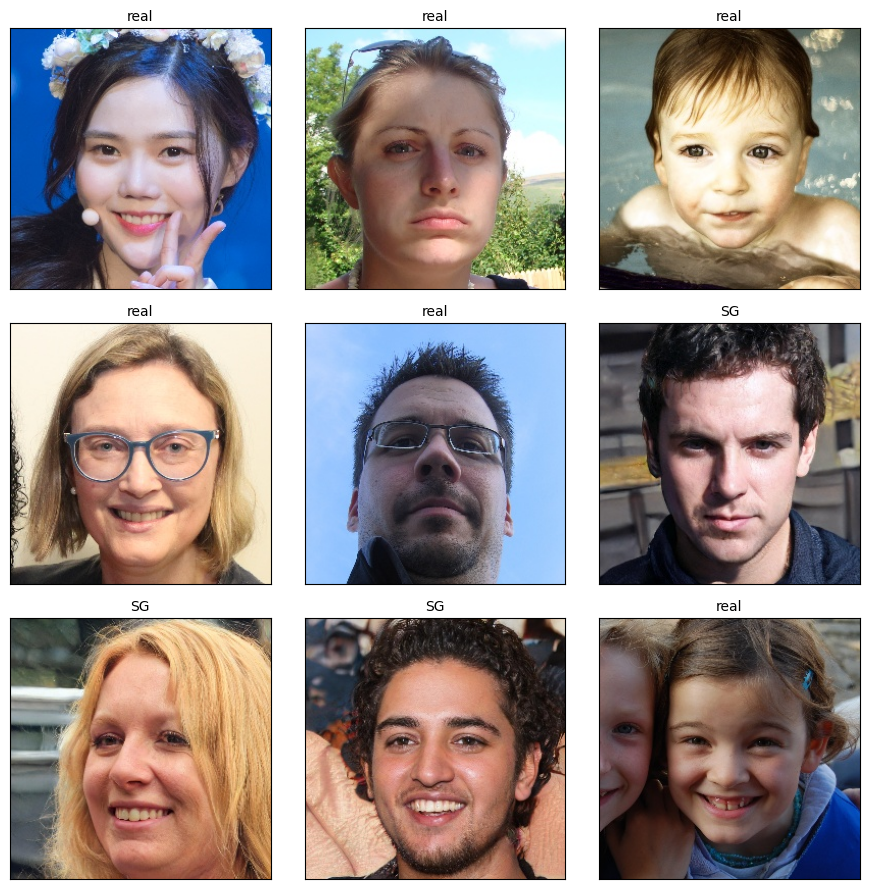

In [ ]:
plt.figure(figsize=(9, 9))
for i in range(9):
    random_index = np.random.randint(0, len(dataset))
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(dataset.iloc[random_index]["image_path"]))
    plt.title(dataset.iloc[random_index]["img_status"], size=10)
    plt.xticks([])
    plt.yticks([])  # Optionally hide y-axis ticks for better visual appeal
plt.tight_layout()
plt.show()

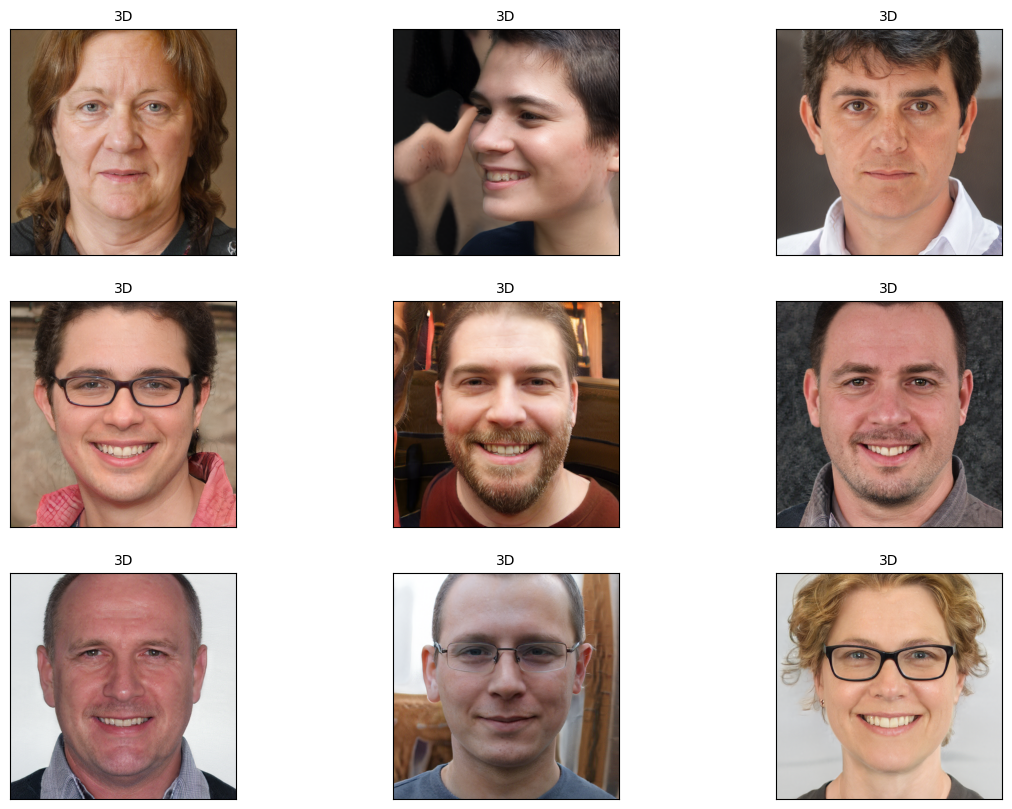

In [ ]:
plt.figure(figsize=(14, 10))
for i in range(9):
    random_index = np.random.randint(0, len(eg3d))
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(eg3d.iloc[random_index]["image_path"]))
    plt.title(eg3d.iloc[random_index]["img_status"], size=10)
    plt.xticks([])
    plt.yticks([])

plt.show()


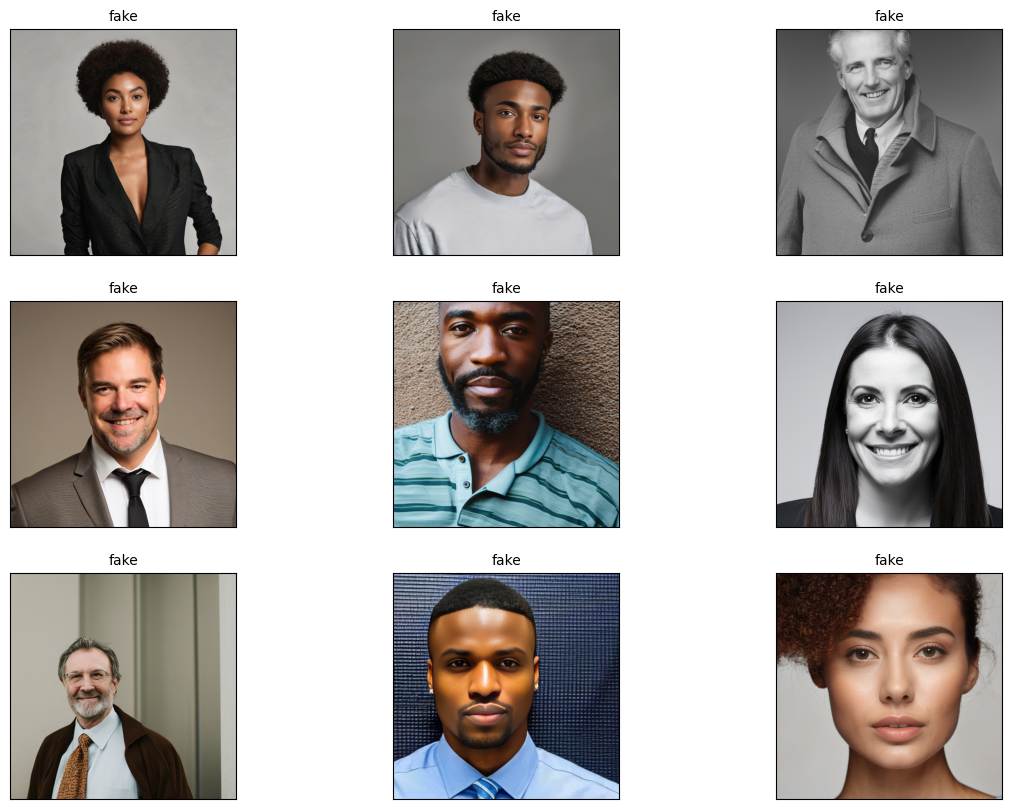

In [ ]:
plt.figure(figsize=(14, 10))
for i in range(9):
    random = np.random.randint(0, len(sd))
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(sd.loc[random, "image_path"]))
    plt.title(sd.loc[random, "img_status"], size=10)
    plt.xticks([])
    plt.yticks([])

plt.show()


In [ ]:
combined_data = pd.concat([dataset, eg3d,sd,sd3,synthetic,real2_df], ignore_index=True)


In [ ]:
combined_data

image_path img_status
0       /kaggle/input/140k-real-and-fake-faces/real_vs...         SG
1       /kaggle/input/140k-real-and-fake-faces/real_vs...         SG
2       /kaggle/input/140k-real-and-fake-faces/real_vs...         SG
3       /kaggle/input/140k-real-and-fake-faces/real_vs...         SG
4       /kaggle/input/140k-real-and-fake-faces/real_vs...         SG
...                                                   ...        ...
236031  /kaggle/input/celebahq-resized-256x256/celeba_...       real
236032  /kaggle/input/celebahq-resized-256x256/celeba_...       real
236033  /kaggle/input/celebahq-resized-256x256/celeba_...       real
236034  /kaggle/input/celebahq-resized-256x256/celeba_...       real
236035  /kaggle/input/celebahq-resized-256x256/celeba_...       real

[236036 rows x 2 columns]

In [ ]:
combined_data.value_counts("img_status")

img_status
real     100000
SG        39500
3D        35000
SFHQ2     25000
SFHQ      25000
fake       9000
sd3        2536
Name: count, dtype: int64

In [ ]:
# Count occurrences of each label
value_counts = combined_data['img_status'].value_counts()

# Combine all labels other than 'Real' into 'Fake'
transformed_counts = value_counts.groupby(lambda x: 'Real' if x == 'real' else 'Fake').sum()

print(transformed_counts)

img_status
Fake    136036
Real    100000
Name: count, dtype: int64


# **Pre-processing and Data preparation**

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the data into 70% train and 30% non-train
train_df, non_train_df = train_test_split(combined_data, test_size=0.28571, random_state=42)

In [ ]:
# Splitting the non-train data into 20% validation and 10% test
validation_df, test_df = train_test_split(non_train_df, test_size=0.25, random_state=42)

# Checking the shapes of the resulting DataFrames
print("Train set shape:", train_df.shape)
print("Validation set shape:", validation_df.shape)
print("Test set shape:", test_df.shape)

Train set shape: (168598, 2)
Validation set shape: (50578, 2)
Test set shape: (16860, 2)


In [ ]:
test_df.value_counts('img_status')

img_status
real     7013
SG       2850
3D       2562
SFHQ2    1826
SFHQ     1805
fake      620
sd3       184
Name: count, dtype: int64

In [ ]:
train_df.value_counts('img_status')

img_status
real     71414
SG       28384
3D       24936
SFHQ2    17800
SFHQ     17791
fake      6447
sd3       1826
Name: count, dtype: int64

In [ ]:
validation_df.value_counts('img_status')

img_status
real     21573
SG        8266
3D        7502
SFHQ      5404
SFHQ2     5374
fake      1933
sd3        526
Name: count, dtype: int64

In [ ]:
# Map all fake data to 0 and real data to 1
validation_df['img_status'] = validation_df['img_status'].map(lambda x: 0 if x != 'real' else 1)
validation_df.value_counts('img_status')

img_status
0    29005
1    21573
Name: count, dtype: int64

In [ ]:
train_df['img_status'] = train_df['img_status'].map(lambda x: 0 if x != 'real' else 1)
train_df.value_counts('img_status')

img_status
0    97184
1    71414
Name: count, dtype: int64

In [ ]:
test_df['img_status'] = test_df['img_status'].map(lambda x: 0 if x != 'real' else 1)
test_df.value_counts('img_status')

img_status
0    9847
1    7013
Name: count, dtype: int64

In [ ]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.0,

)

In [ ]:
train = image_gen.flow_from_dataframe(
    dataframe=train_df,
    target_size=(260, 260),
    batch_size=100,
    color_mode='rgb',
    class_mode='raw',  # Set class_mode to 'raw'= labels can be numeric (0 , 1)
    shuffle=True,
    x_col='image_path',  # Specify the column name containing file paths
    y_col='img_status'  # Specify the column name containing class labels
)

Found 168598 validated image filenames.


In [ ]:
valid = image_gen.flow_from_dataframe(
    dataframe=validation_df,
    target_size=(260, 260),
    batch_size=100,
    color_mode='rgb',
    class_mode='raw',  # Set class_mode to 'raw'= labels can be numeric (0 , 1)
    shuffle=True,
    x_col='image_path',  # Specify the column name containing file paths
    y_col='img_status'  # Specify the column name containing class labels
)

Found 50578 validated image filenames.


In [ ]:
test = image_gen.flow_from_dataframe(
    dataframe=test_df,
    target_size=(260, 260),
    batch_size=100,
    color_mode='rgb',
    class_mode='raw',  # Set class_mode to 'raw'= labels can be numeric (0 , 1)
    shuffle=True,
    x_col='image_path',  # Specify the column name containing file paths
    y_col='img_status'  # Specify the column name containing class labels
)

Found 16860 validated image filenames.


In [ ]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
input_shape = (260, 260,3)  # Adjust based on your actual image dimensions and channels1

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu',name='last_conv'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

checkpoint_path = "best_weights.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

callbacks = [checkpoint, early_stopping]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 258, 258, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 129, 129, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 127, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 63, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

In [ ]:
history = model.fit(
    train, # change to train_generator,  remove comments, make the epochs 10
    steps_per_epoch = (100000//100),
    validation_data = valid,
    validation_steps = (20000//100),
    epochs = 10
)

Epoch 1/10


I0000 00:00:1717552522.774650      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1000/1000 [==============================] - 1440s 1s/step - loss: 0.4383 - accuracy: 0.7821 - val_loss: 0.3510 - val_accuracy: 0.8372
Epoch 2/10
1000/1000 [==============================] - 1153s 1s/step - loss: 0.3228 - accuracy: 0.8533 - val_loss: 0.2911 - val_accuracy: 0.8683
Epoch 3/10
1000/1000 [==============================] - 988s 988ms/step - loss: 0.2661 - accuracy: 0.8833 - val_loss: 0.2358 - val_accuracy: 0.8990
Epoch 4/10
1000/1000 [==============================] - 1014s 1s/step - loss: 0.2243 - accuracy: 0.9050 - val_loss: 0.2281 - val_accuracy: 0.9051
Epoch 5/10
1000/1000 [==============================] - 1035s 1s/step - loss: 0.1890 - accuracy: 0.9222 - val_loss: 0.1842 - val_accuracy: 0.9251
Epoch 6/10
1000/1000 [==============================] - 1004s 1s/step - loss: 0.1615 - accuracy: 0.9346 - val_loss: 0.2140 - val_accuracy: 0.9151
Epoch 7/10
1000/1000 [==============================] - 997s 997ms/step - loss: 0.1412 - accuracy: 0.9432 - val_loss: 0.1694 - val_ac

In [ ]:
model.save('Real VS Fake.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


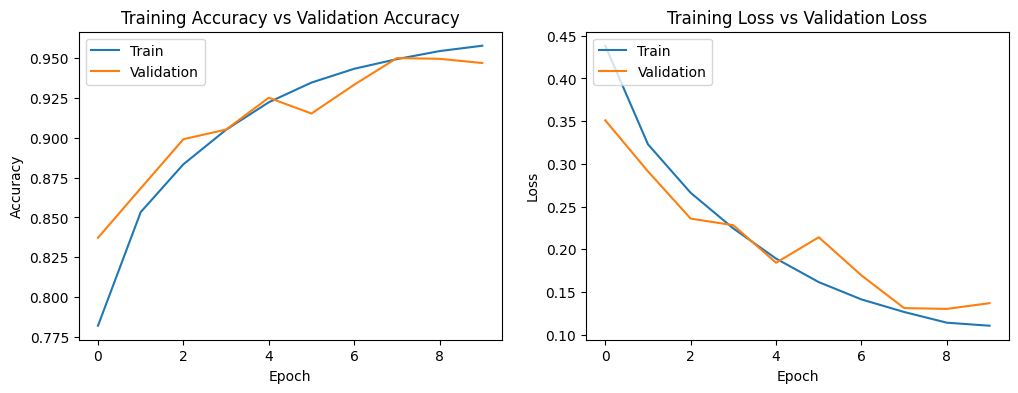

In [ ]:
# plot the graphs that shows the progress of the training of each epoch and compare the training accuracy with the validation accuracy

fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

169/169 [==============================] - 239s 1s/step


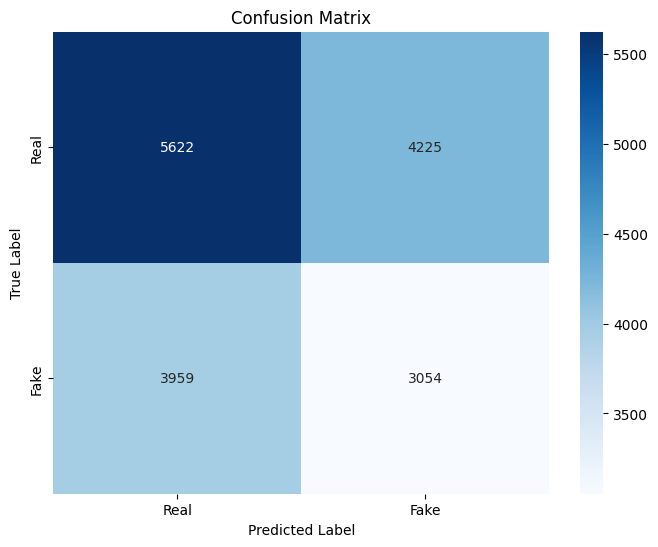

Classification Report:
              precision    recall  f1-score   support

        Real       0.59      0.57      0.58      9847
        Fake       0.42      0.44      0.43      7013

    accuracy                           0.51     16860
   macro avg       0.50      0.50      0.50     16860
weighted avg       0.52      0.51      0.52     16860



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a test_generator for generating test data
# Generate predictions
predictions = model.predict(test)
# Convert predictions to binary labels
predicted_labels = np.round(predictions).flatten()

# Get true labels
true_labels = test.labels

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(true_labels, predicted_labels, target_names=['Real', 'Fake'])

# Print classification report
print("Classification Report:")
print(class_report)

In [ ]:
pip install tf-explain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


/opt/conda/lib/python3.10/site-packages/tf_explain/utils/display.py:112: RuntimeWarning: invalid value encountered in divide
  heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())
/opt/conda/lib/python3.10/site-packages/tf_explain/utils/display.py:115: RuntimeWarning: invalid value encountered in cast
  cv2.cvtColor((heatmap * 255).astype("uint8"), cv2.COLOR_GRAY2BGR), colormap


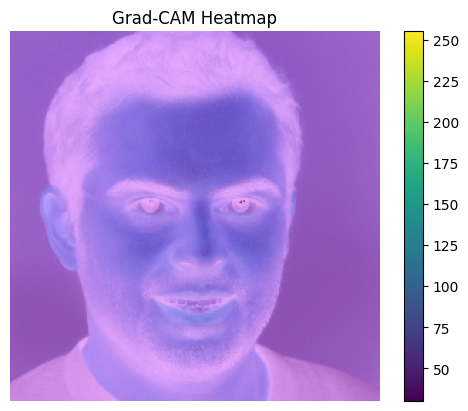

In [ ]:
import numpy as np
import tensorflow as tf
from tf_explain.core.grad_cam import GradCAM
import matplotlib.pyplot as plt

# Assuming you already loaded your model and defined preprocess_image function as in your code

# Your code to obtain the Grad-CAM explanation
model = tf.keras.models.load_model('/kaggle/working/Real VS Fake.h5')

def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(260, 260), color_mode="rgb")
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    return np.expand_dims(img_array, axis=0)

image_path = '/kaggle/input/synthetic-faces-high-quality-sfhq-part-3/images/images/SFHQ_pt3_00000001.jpg'
image = preprocess_image(image_path)
explainer = GradCAM()
grid = explainer.explain((image, None), model, class_index=0, layer_name='last_conv')

# Plot the heatmap
plt.imshow(grid, cmap='viridis')  # Choose the appropriate colormap
plt.colorbar()  # Add a colorbar to indicate values
plt.title('Grad-CAM Heatmap')
plt.axis('off')  # Hide axis
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


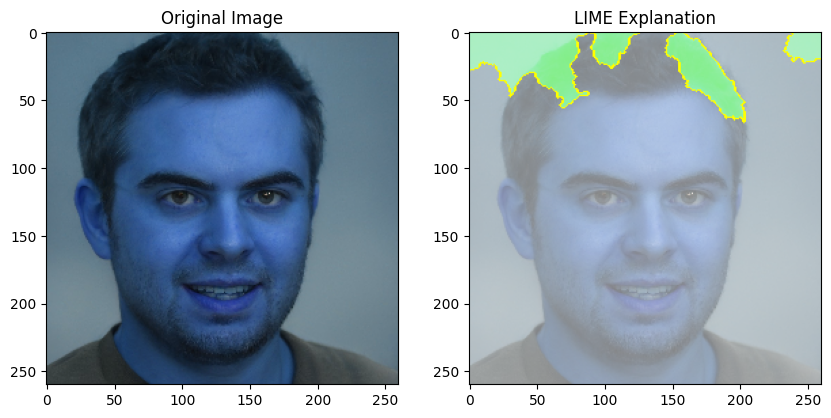

In [ ]:
import numpy as np
import cv2
from keras.models import load_model
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from lime import lime_image

# Load the model
model = load_model('/kaggle/working/Real VS Fake.h5')

# Load and preprocess a sample image
sample_img_path = '/kaggle/input/synthetic-faces-high-quality-sfhq-part-3/images/images/SFHQ_pt3_00000001.jpg'  # Replace with your sample image path
sample_img = cv2.imread(sample_img_path)
sample_img = cv2.resize(sample_img, (260, 260))  # Resize to match model input shape
sample_img = sample_img / 255.0  # Normalize
sample_img = np.expand_dims(sample_img, axis=0)  # Add batch dimension

# Define the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain predictions
explanation = explainer.explain_instance(sample_img[0], model.predict, top_labels=1, num_samples=1000)

# Get the explanation image and mask
temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=5, hide_rest=False)

# Display results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(sample_img[0])
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title('LIME Explanation')

plt.show()